# Preliminary: SHAP and XGBoost 

In [1]:

import shap
# import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
# from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor


## Load dataset


In [2]:
combinedbuoyspath = "../data/plankton-patrol/Plankton Patrol/Data/plank_ChesapeakeBay_all_buoys_clean.csv"
data = pd.read_csv(combinedbuoyspath)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6222422 entries, 0 to 6222421
Data columns (total 36 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Latitude_x               float64
 1   Longitude_x              float64
 2   Air Temperature QC       float64
 3   Air Temperature          float64
 4   Air pressure QC          float64
 5   Air pressure             float64
 6   Humidity QC              float64
 7   Humidity                 float64
 8   Wind speed QC            float64
 9   Wind speed               float64
 10  Wind Direction QC        float64
 11  Wind Direction           float64
 12  Latitude_y               float64
 13  Longitude_y              float64
 14  Temperature QC           float64
 15  Temperature              float64
 16  Salinity QC              float64
 17  Salinity                 float64
 18  Chlorophyll QC           float64
 19  Chlorophyll              float64
 20  Turbidity QC             float64
 21  Turbidit

### Inspect column names

In [3]:
data.columns

Index(['Latitude_x', 'Longitude_x', 'Air Temperature QC', 'Air Temperature',
       'Air pressure QC', 'Air pressure', 'Humidity QC', 'Humidity',
       'Wind speed QC', 'Wind speed', 'Wind Direction QC', 'Wind Direction',
       'Latitude_y', 'Longitude_y', 'Temperature QC', 'Temperature',
       'Salinity QC', 'Salinity', 'Chlorophyll QC', 'Chlorophyll',
       'Turbidity QC', 'Turbidity', 'Oxygen QC', 'Oxygen', 'Waves QC',
       'Significant wave height', 'Wave from direction', 'Wave period',
       'North surface currents', 'East surface currents', 'Sample_year',
       'Sample_month', 'Sample_day', 'Sample_hour', 'Sample_minute',
       'Sample_second'],
      dtype='object')

In [4]:
def get_valid_value(row, col1, col2, min_valid, max_valid):
    
    if pd.notna(row[col1]) and min_valid <= row[col1] <= max_valid:
        return row[col1]
    elif pd.notna(row[col2]) and min_valid <= row[col2] <= max_valid:
        return row[col2]
    else:
        return np.nan


def merge_valid_if_equal(df, col1, col2, constraint_type, newcol=None, show_diffs=True):
    # Check if the columns are the same
    condition =df[col1] != df[col2]
    df_diffs = df[condition]
    df.loc[condition, col1] = df.loc[condition, col1].fillna(df[col1])
    df.loc[condition, col2] = df.loc[condition, col2].fillna(df[col2])
    # df = df.fillna(-999)
    if show_diffs:
        print(df_diffs[[col1, col2]])
    if newcol is None:
        newcol = constraint_type
    if constraint_type == "Latitude":
        minval, maxval = -90, 90
    if constraint_type == "Longitude":
        minval, maxval = -180, 180
    # if df[col1].equals(df[col2]):
    # Merge the columns into a new column
    df[newcol] = df.apply(get_valid_value, axis=1, args=(col1, col2, minval, maxval))
    df.drop([col1, col2], axis=1, inplace=True)
    return df
    # else:
    #     raise ValueError("The columns are not identical, cannot merge")


# def add_constraints(df, col, constraint_type):
#     if constraint_type == "Latitude":
#         df_filtered = df[(df[col] >= -90) & (df[col] <= 90)]

#     if constraint_type == "Longitude":
#         df_filtered = df[(df[col] >= -180) & (df[col] <= 180)]

#     return df_filtered

In [5]:
data_temp1 = merge_valid_if_equal(data, 'Latitude_x','Latitude_y', 'Latitude')
data_temp2 = merge_valid_if_equal(data_temp1, 'Longitude_x','Longitude_y', 'Longitude')
data_temp2




         Latitude_x  Latitude_y
0          39.20141         NaN
1          39.20141         NaN
2          39.20141         NaN
3           0.00000         NaN
4          39.20142         NaN
...             ...         ...
6222417         NaN         NaN
6222418         NaN         NaN
6222419         NaN         NaN
6222420         NaN         NaN
6222421         NaN         NaN

[3700815 rows x 2 columns]
         Longitude_x  Longitude_y
0          -76.57479          NaN
1          -76.57486          NaN
2          -76.57480          NaN
3                NaN          NaN
4          -76.57483          NaN
...              ...          ...
6222417          NaN          NaN
6222418          NaN          NaN
6222419          NaN          NaN
6222420          NaN          NaN
6222421          NaN          NaN

[3719365 rows x 2 columns]


,Air Temperature QC,Air Temperature,Air pressure QC,Air pressure,Humidity QC,Humidity,Wind speed QC,Wind speed,Wind Direction QC,Wind Direction,...,North surface currents,East surface currents,Sample_year,Sample_month,Sample_day,Sample_hour,Sample_minute,Sample_second,Latitude,Longitude
0,1.0,14.4,1.0,1028.18,1.0,66.8,1.0,1.0,1.0,155.0,...,NaN,NaN,2009,11,18,19,10,0,39.20141,-76.57479
1,1.0,14.4,1.0,1028.22,1.0,67.1,1.0,0.9,1.0,164.0,...,NaN,NaN,2009,11,18,19,20,0,39.20141,-76.57486
2,1.0,14.4,1.0,1028.30,1.0,67.2,1.0,1.0,1.0,182.0,...,NaN,NaN,2009,11,18,19,30,0,39.20141,-76.57480
3,1.0,14.4,1.0,1028.12,1.0,67.0,1.0,1.0,1.0,174.0,...,NaN,NaN,2009,11,18,19,40,0,0.00000,NaN
4,1.0,14.4,1.0,1028.01,1.0,67.7,1.0,1.0,1.0,174.0,...,NaN,NaN,2009,11,18,19,50,0,39.20142,-76.57483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6222417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-255.73,106.93,2024,7,28,12,24,0,NaN,NaN
6222418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-260.60,100.19,2024,7,28,12,30,0,NaN,NaN
6222419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-286.61,106.20,2024,7,28,12,36,0,NaN,NaN
6222420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-282.31,100.71,2024,7,28,12,42,0,NaN,NaN


In [6]:
data_temp2.head()
# raise Exception

,Air Temperature QC,Air Temperature,Air pressure QC,Air pressure,Humidity QC,Humidity,Wind speed QC,Wind speed,Wind Direction QC,Wind Direction,...,North surface currents,East surface currents,Sample_year,Sample_month,Sample_day,Sample_hour,Sample_minute,Sample_second,Latitude,Longitude
0,1.0,14.4,1.0,1028.18,1.0,66.8,1.0,1.0,1.0,155.0,...,NaN,NaN,2009,11,18,19,10,0,39.20141,-76.57479
1,1.0,14.4,1.0,1028.22,1.0,67.1,1.0,0.9,1.0,164.0,...,NaN,NaN,2009,11,18,19,20,0,39.20141,-76.57486
2,1.0,14.4,1.0,1028.30,1.0,67.2,1.0,1.0,1.0,182.0,...,NaN,NaN,2009,11,18,19,30,0,39.20141,-76.57480
3,1.0,14.4,1.0,1028.12,1.0,67.0,1.0,1.0,1.0,174.0,...,NaN,NaN,2009,11,18,19,40,0,0.00000,NaN
4,1.0,14.4,1.0,1028.01,1.0,67.7,1.0,1.0,1.0,174.0,...,NaN,NaN,2009,11,18,19,50,0,39.20142,-76.57483


In [7]:
data_clean = data_temp2.replace([np.inf, -np.inf], np.nan)
missing_percentage = data_clean.isnull().mean()
print(missing_percentage)
clean_columns = data_clean.columns.tolist()

# Drop columns where more than 90% of the data is missing
columns_to_drop = missing_percentage[missing_percentage > 0.90].index
print(columns_to_drop)
data_clean = data.dropna(subset=['Chlorophyll'])

Air Temperature QC         0.017259
Air Temperature            0.010831
Air pressure QC            0.017293
Air pressure               0.009750
Humidity QC                0.182650
Humidity                   0.332568
Wind speed QC              0.015141
Wind speed                 0.020568
Wind Direction QC          0.014936
Wind Direction             0.020362
Temperature QC             0.587705
Temperature                0.622787
Salinity QC                0.587770
Salinity                   0.622860
Chlorophyll QC             0.765590
Chlorophyll                0.792112
Turbidity QC               0.765551
Turbidity                  0.792067
Oxygen QC                  0.765480
Oxygen                     0.792161
Waves QC                   0.655877
Significant wave height    0.712695
Wave from direction        0.712720
Wave period                0.712723
North surface currents     0.623581
East surface currents      0.623581
Sample_year                0.000000
Sample_month               0

In [8]:
data_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1293567 entries, 105 to 6222003
Data columns (total 34 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Air Temperature QC       1226801 non-null  float64
 1   Air Temperature          1250155 non-null  float64
 2   Air pressure QC          1227302 non-null  float64
 3   Air pressure             1251746 non-null  float64
 4   Humidity QC              1225124 non-null  float64
 5   Humidity                 756797 non-null   float64
 6   Wind speed QC            1227974 non-null  float64
 7   Wind speed               1221953 non-null  float64
 8   Wind Direction QC        1228199 non-null  float64
 9   Wind Direction           1222178 non-null  float64
 10  Temperature QC           1264731 non-null  float64
 11  Temperature              1293473 non-null  float64
 12  Salinity QC              1264608 non-null  float64
 13  Salinity                 1293363 non-null  fl

In [9]:
X, y = data_clean.drop(['Chlorophyll'], axis=1), data_clean['Chlorophyll']

# X = pd.get_dummies(X, drop_first=True) # TOO much memory
# Label encode categorical variables
for col in X.select_dtypes(include=['category']).columns:
    X[col] = X[col].cat.codes
X.shape, y.shape

((1293567, 33), (1293567,))

# Visualize data

In [10]:
import matplotlib.pyplot as plt
def visualize_param_map(df, parameter, path):
    latitude = df['Latitude']
    longitude = df['Longitude']
    cha = df[parameter]

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(longitude, latitude, c=cha, cmap='coolwarm', marker='o')

    # Add a color bar
    plt.colorbar(scatter, label=f'{parameter}')
    plt.xlim(-76.5, -75.9)
    plt.ylim(36.5, 40)

    # Add labels and title
    plt.title(f'{parameter} Map')
    plt.xlabel('Latitude')
    plt.ylabel('Latitude')

    # Display the plot
    plt.grid(True)
    # plt.show()
    plt.savefig(path)

Visualize parameters

C:\Users\pushk\AppData\Local\Temp\ipykernel_22704\1147175026.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


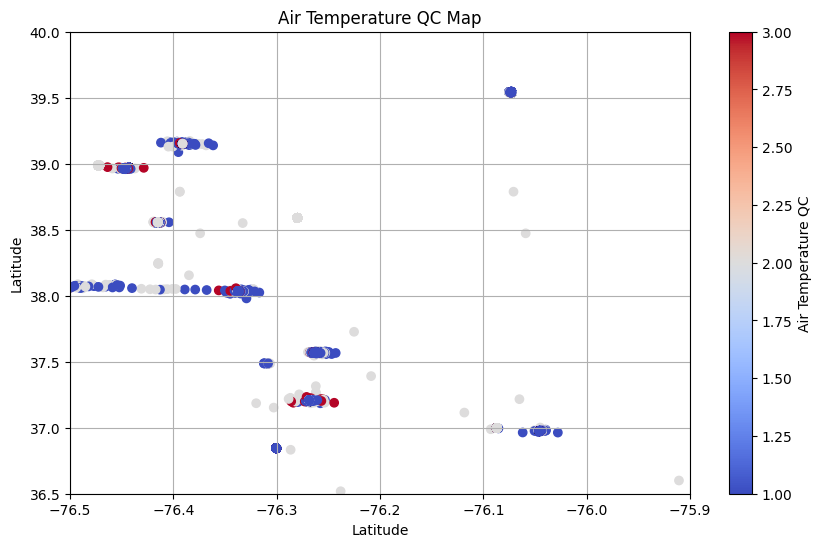

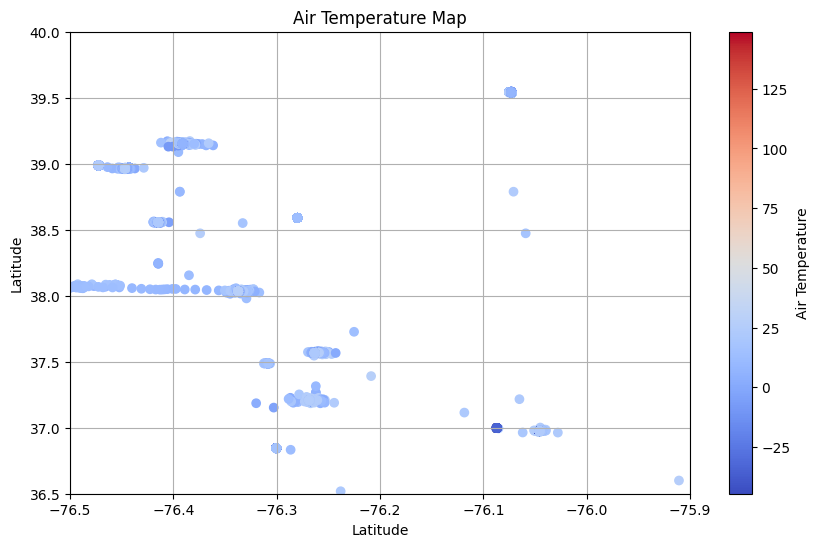

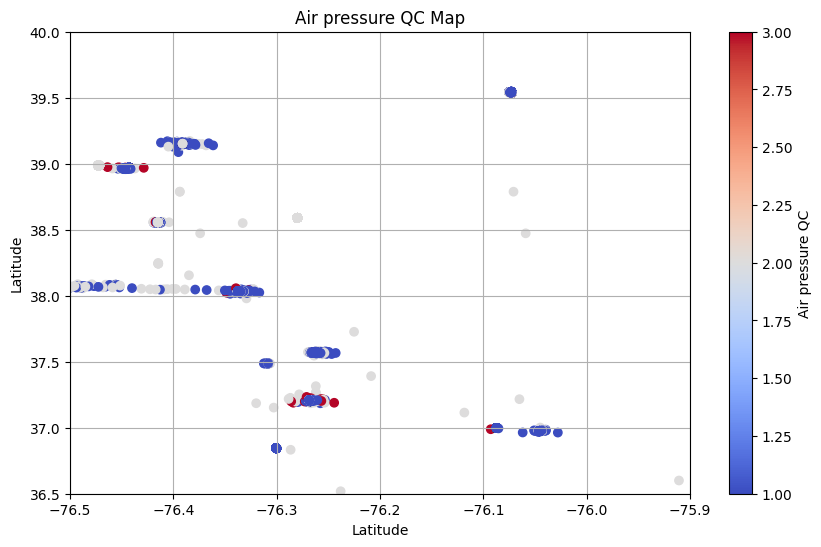

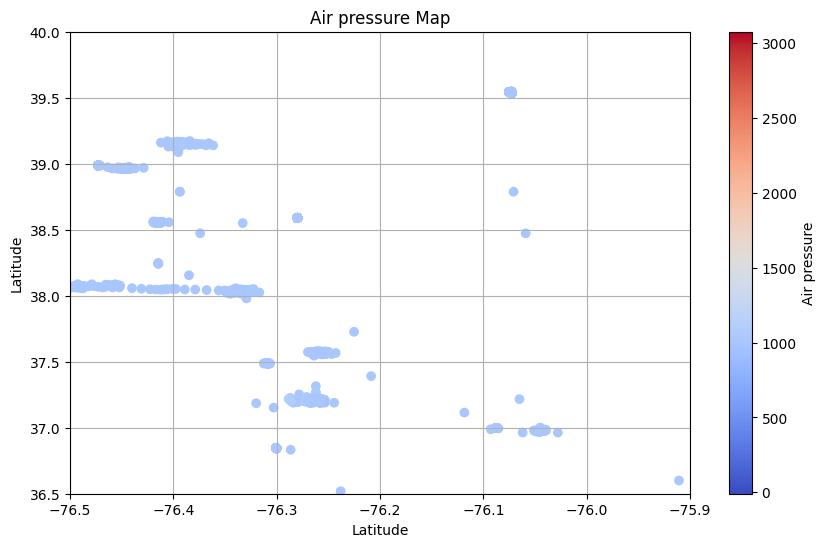

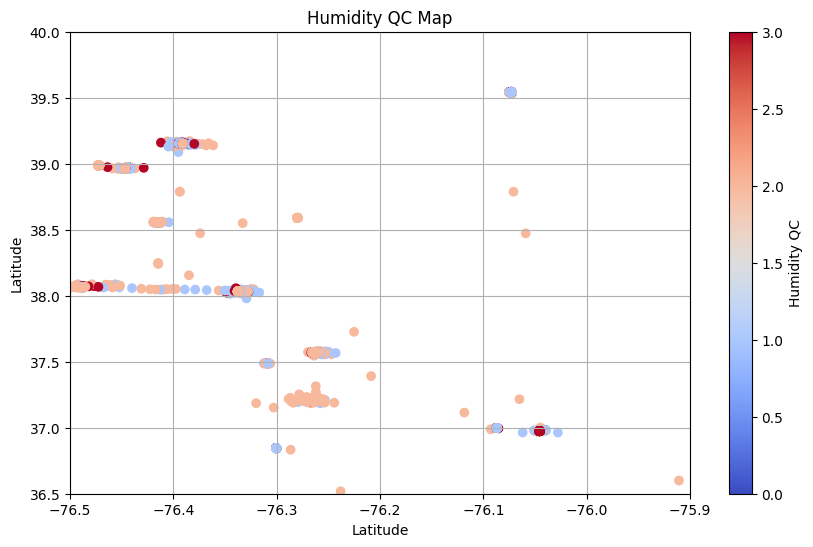

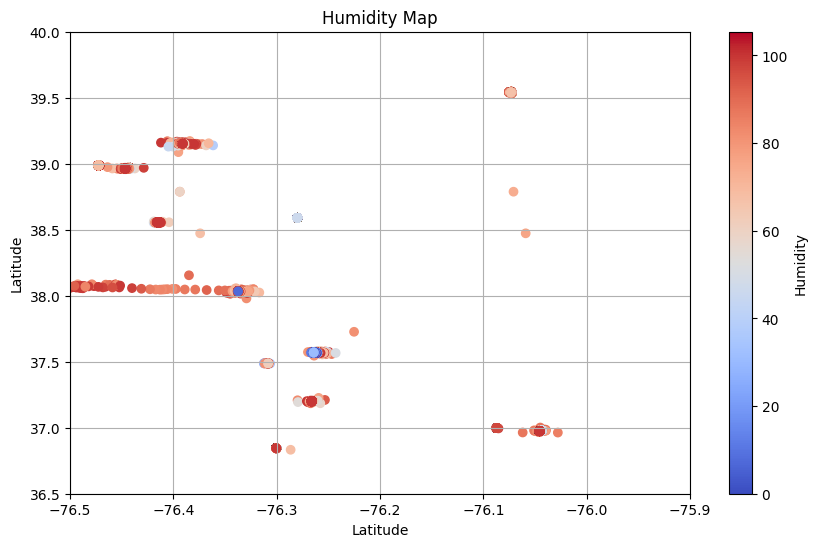

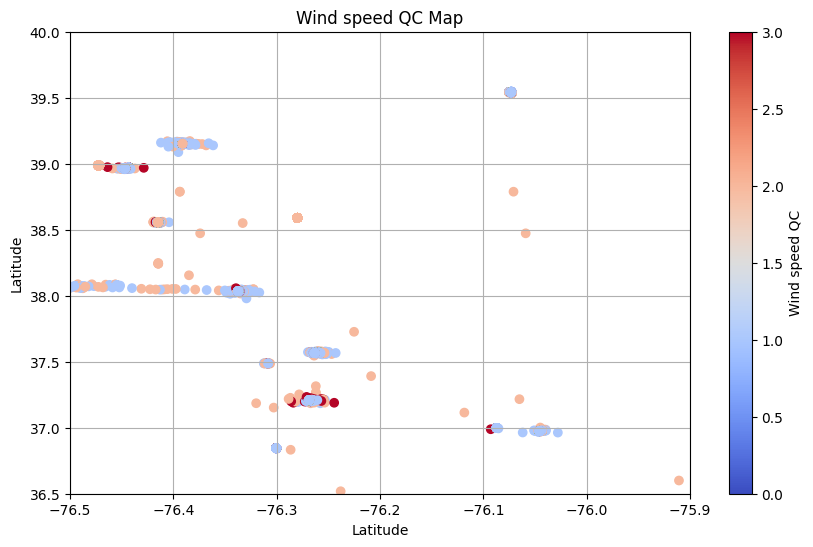

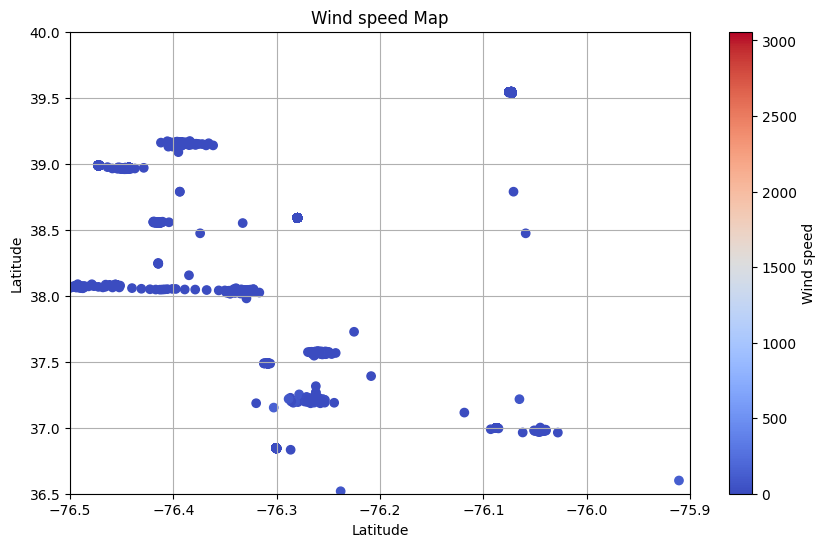

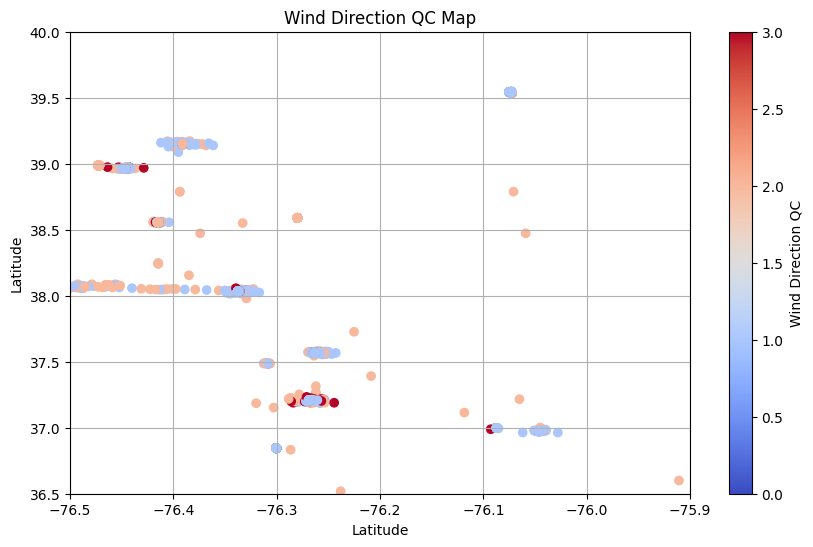

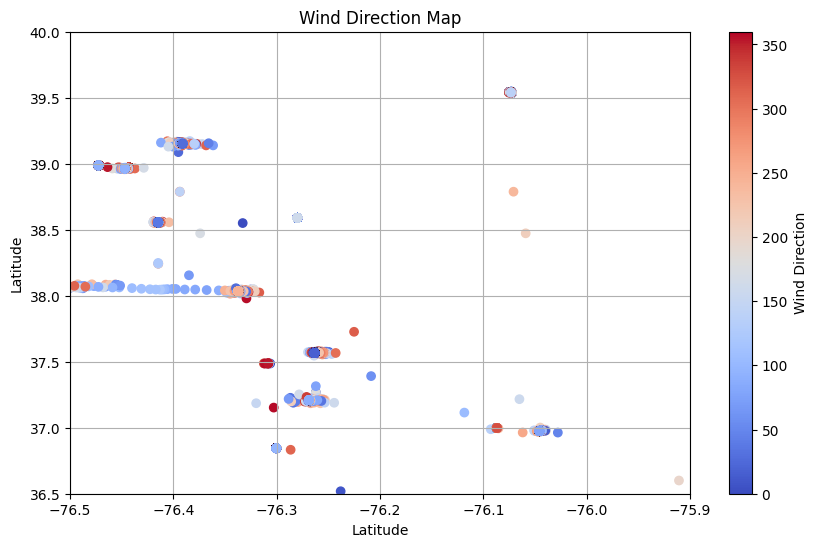

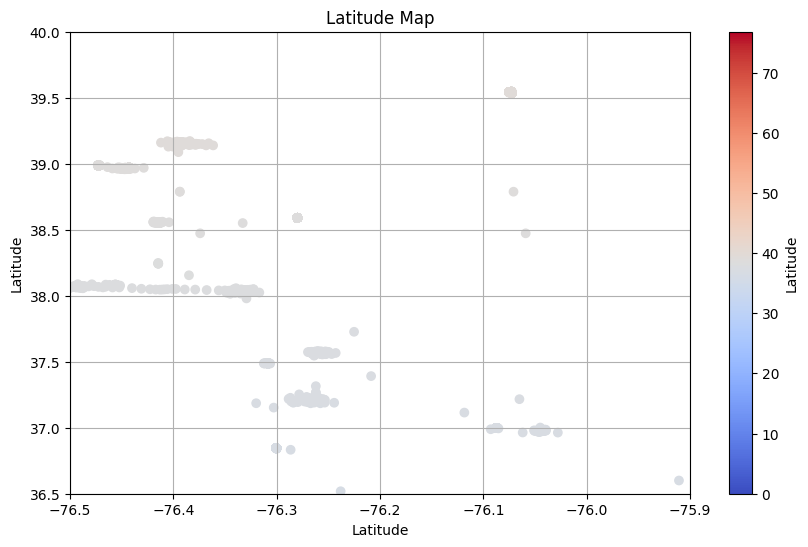

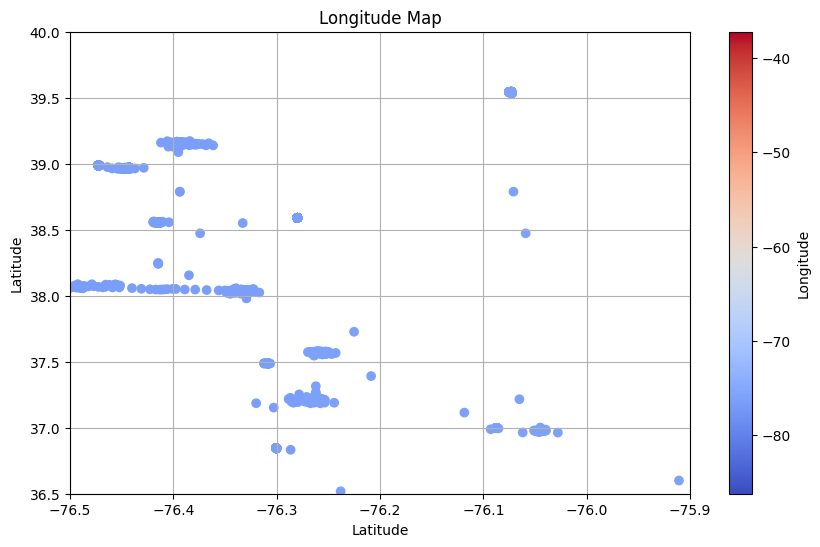

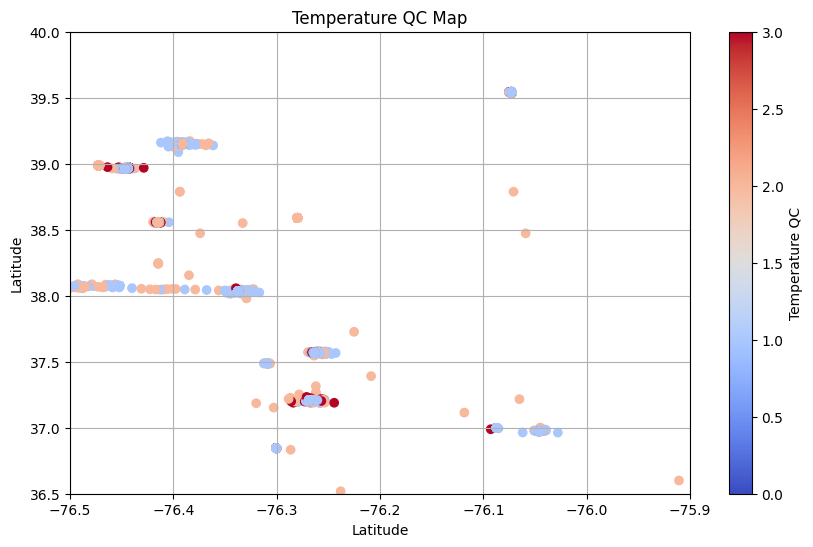

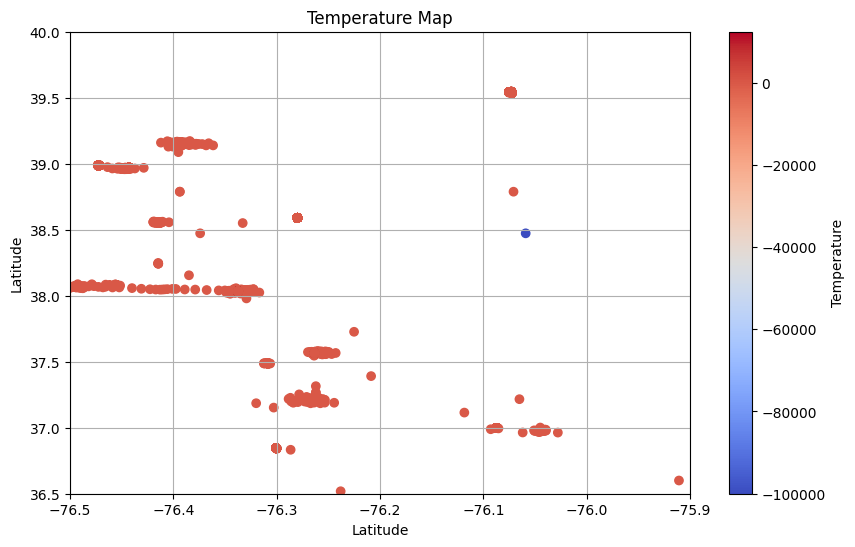

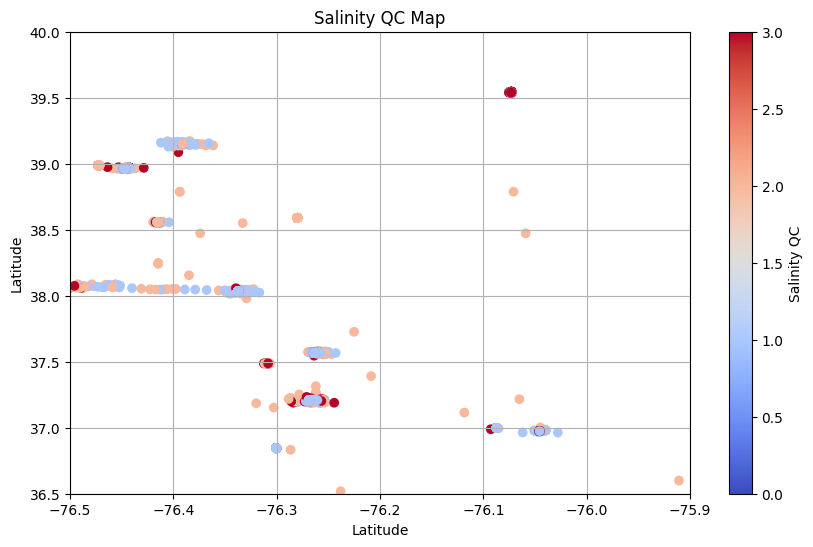

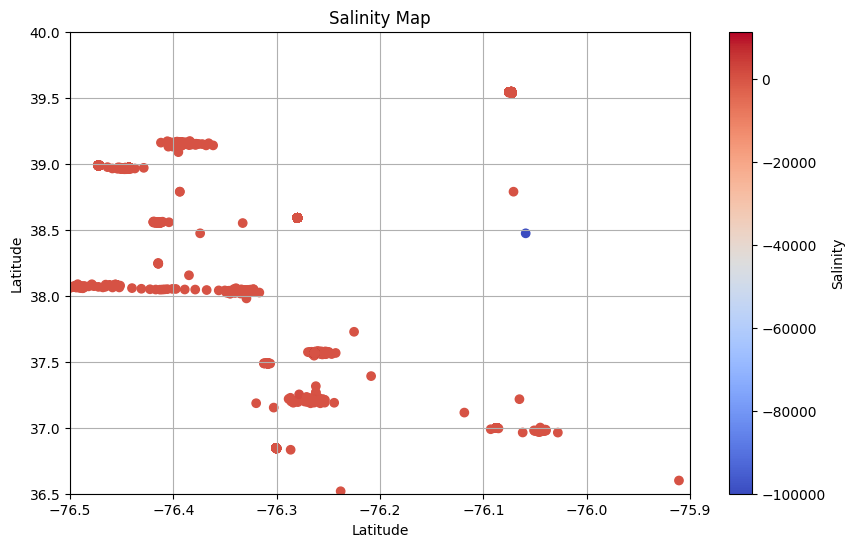

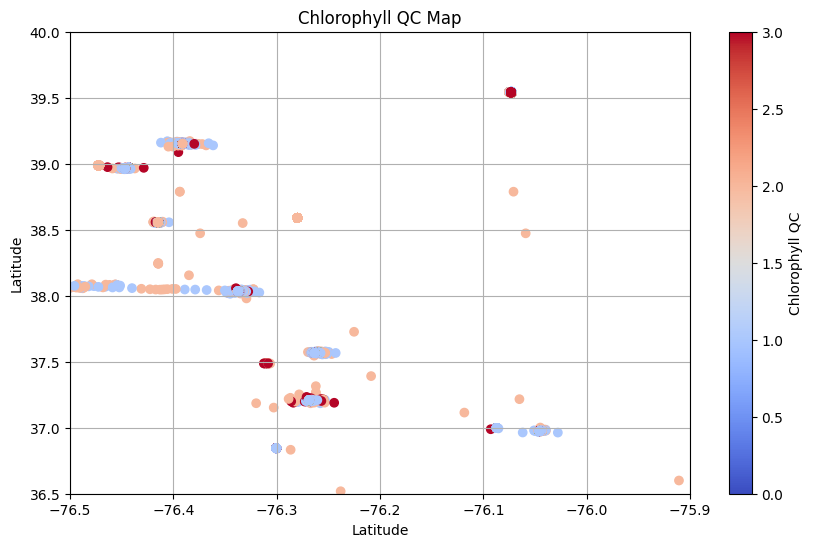

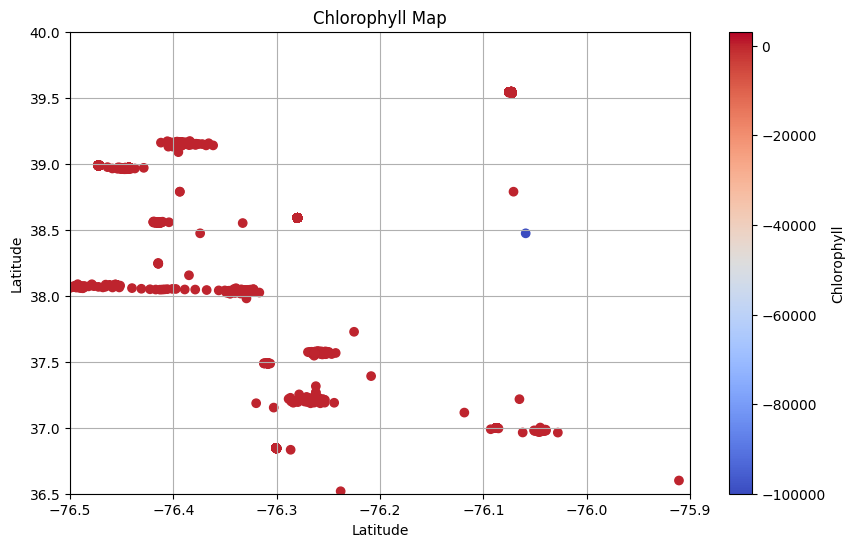

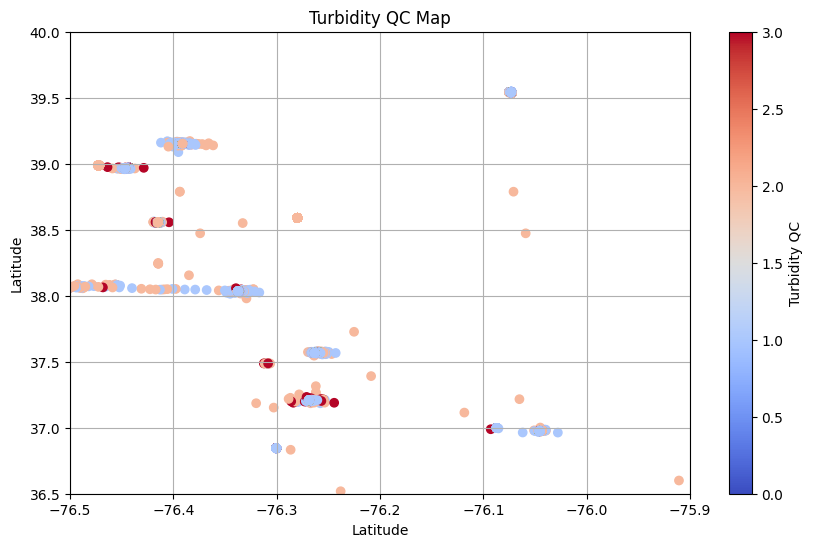

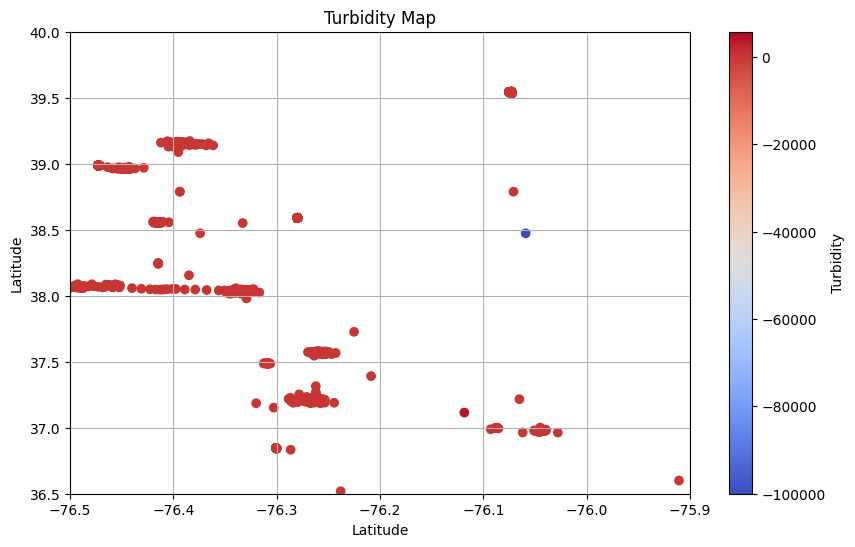

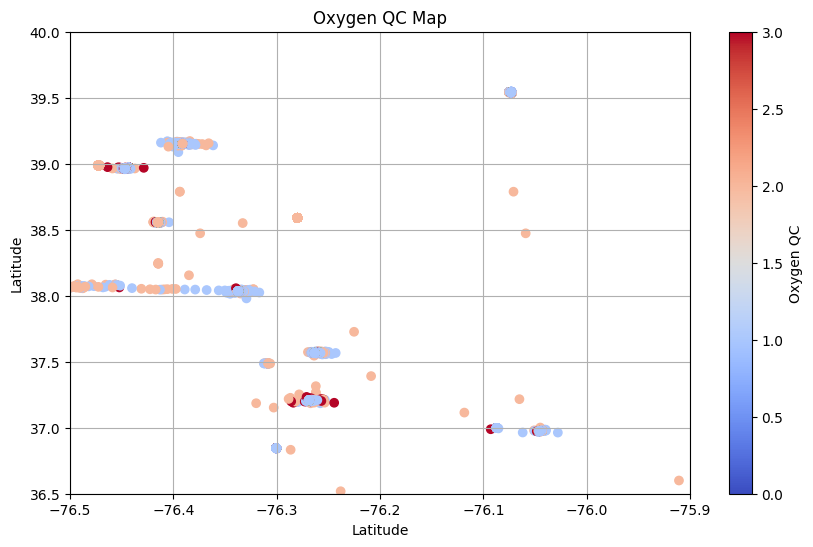

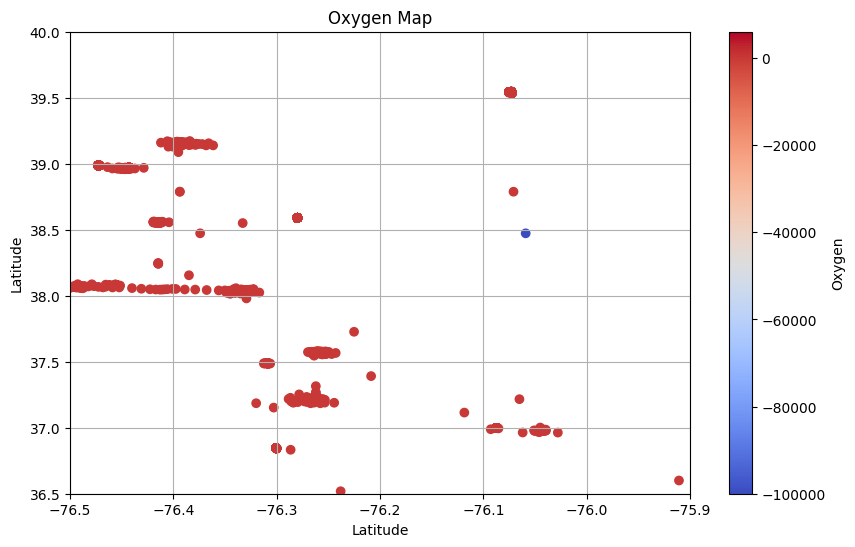

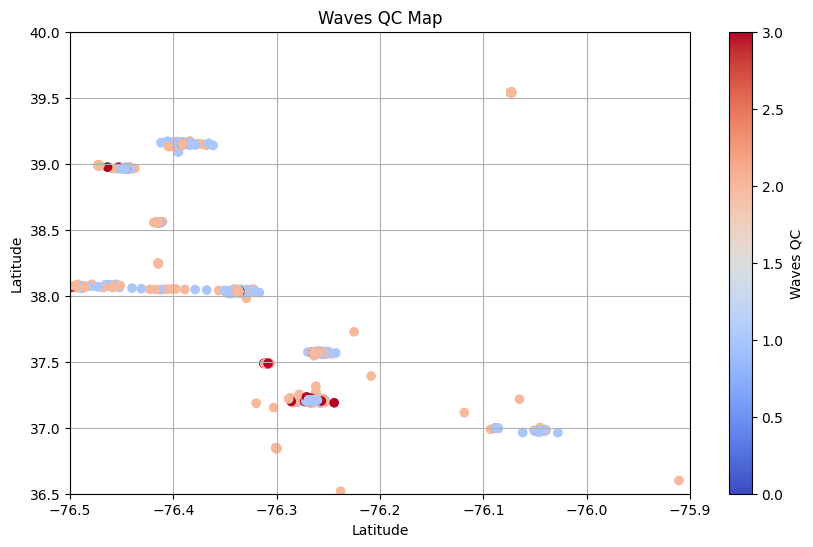

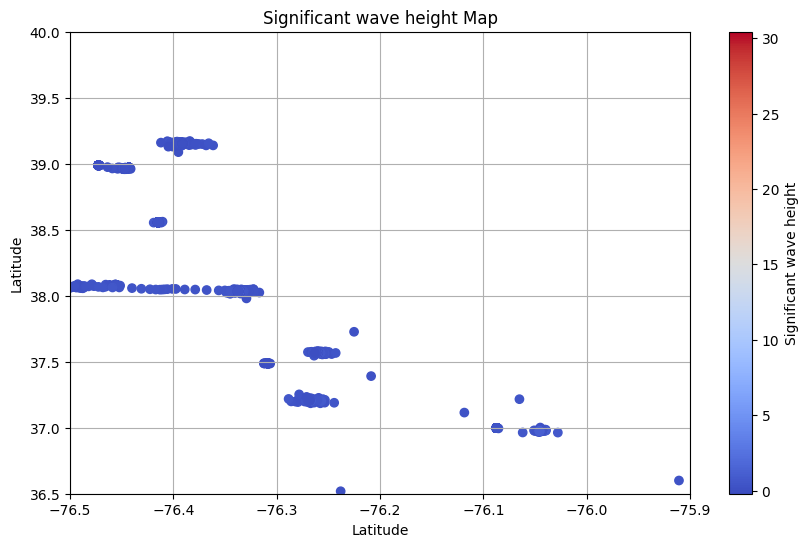

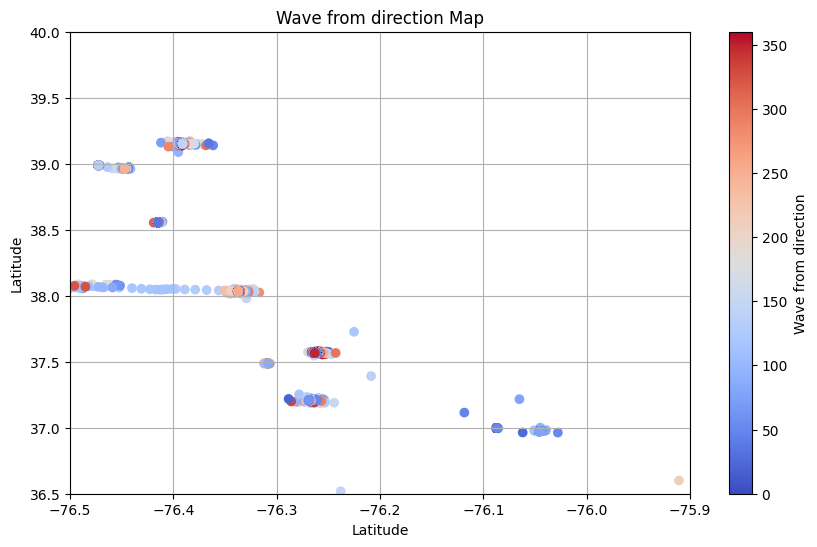

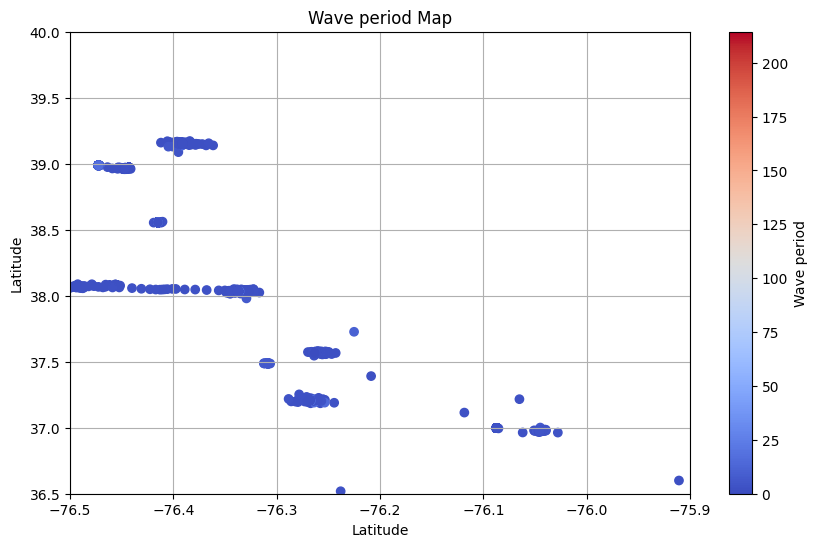

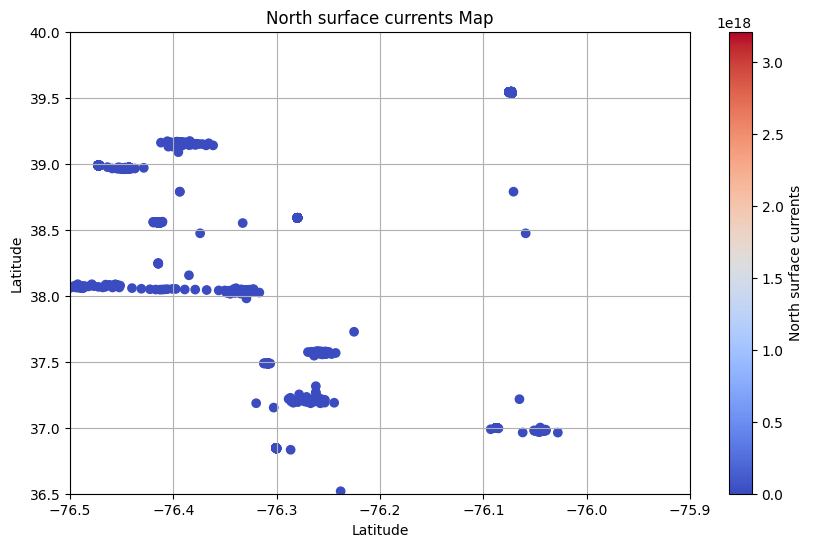

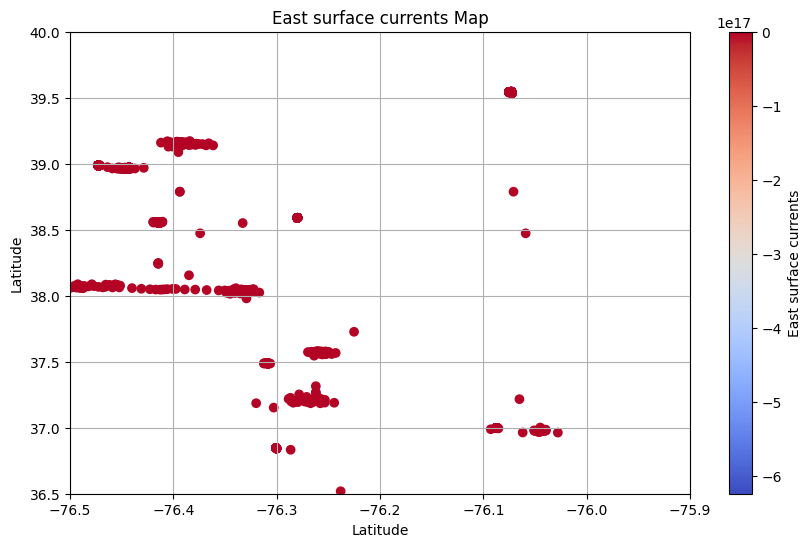

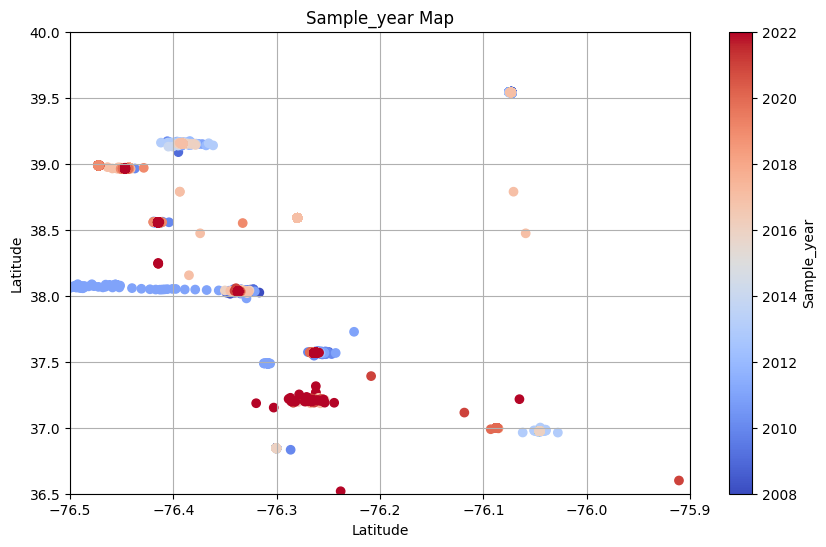

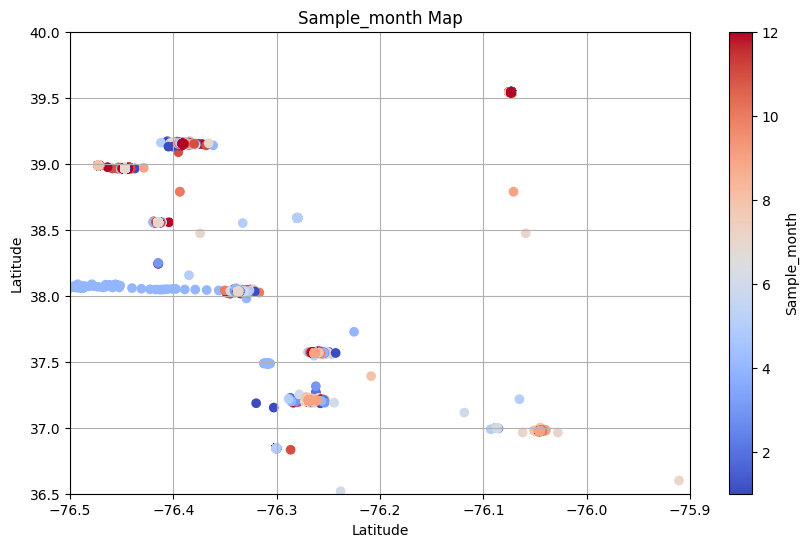

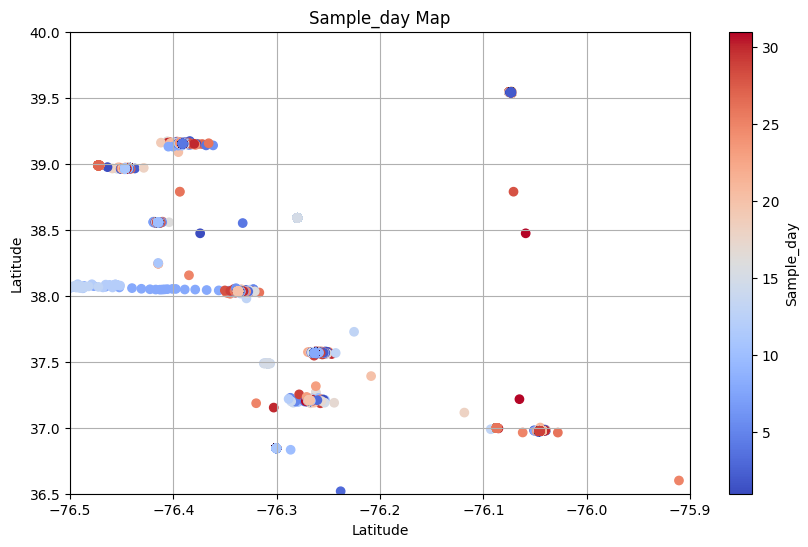

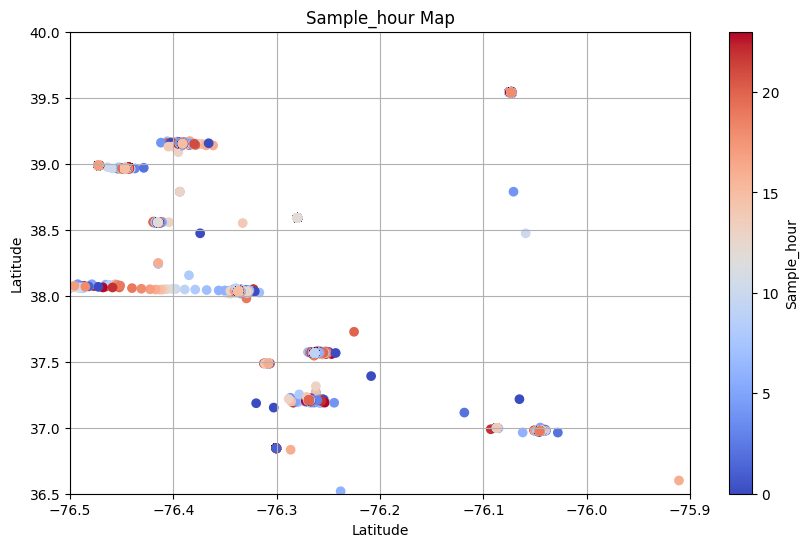

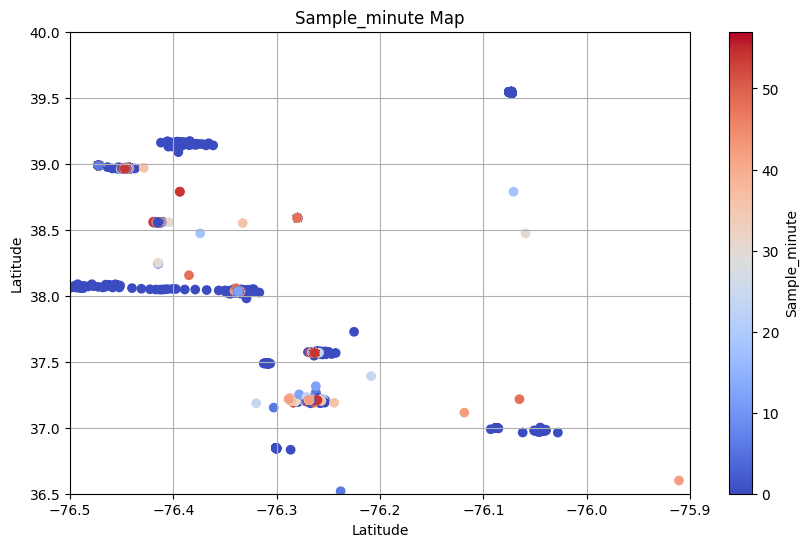

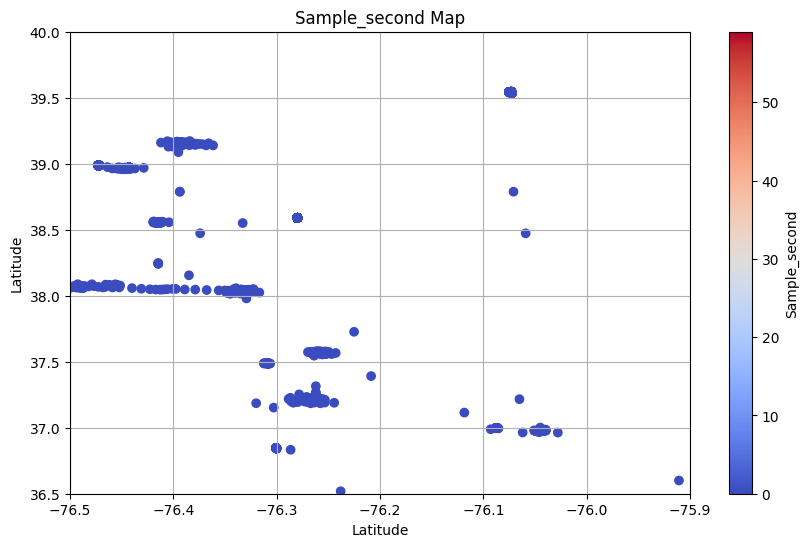

In [11]:
listparams =['Air Temperature QC', 'Air Temperature',
       'Air pressure QC', 'Air pressure', 'Humidity QC', 'Humidity',
       'Wind speed QC', 'Wind speed', 'Wind Direction QC', 'Wind Direction',
       'Latitude', 'Longitude', 'Temperature QC', 'Temperature',
       'Salinity QC', 'Salinity', 'Chlorophyll QC', 'Chlorophyll',
       'Turbidity QC', 'Turbidity', 'Oxygen QC', 'Oxygen', 'Waves QC',
       'Significant wave height', 'Wave from direction', 'Wave period',
       'North surface currents', 'East surface currents', 'Sample_year',
       'Sample_month', 'Sample_day', 'Sample_hour', 'Sample_minute',
       'Sample_second']


import os
path = "../data/visualizations/buoys"
if not os.path.exists(path):
       os.mkdir(path)
for p in listparams:
    visualize_param_map(data_clean, p, os.path.join(path, f"{p}.png"))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train an XGBoost model

In [ ]:
# Define the parameter grid to search over
# model = xgboost.XGBRegressor(
#     max_depth=3,  # Maximum depth of a tree
#     learning_rate=0.1,  # Learning rate
#     n_estimators=100,  # Number of trees
#     subsample=0.8,  # Subsample ratio of the training instances
#     colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
#     gamma=0,  # Minimum loss reduction required to make a further partition
#     min_child_weight=1,  # Minimum sum of instance weight needed in a child
#     device="cuda",
#     enable_categorical=True,
# )
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "n_estimators": [50, 100, 200],
}
models = {
    # "MLPRegressor": (
    #     MLPRegressor(max_iter=1000),
    #     {"hidden_layer_sizes": [(50, 50), (100,)], "learning_rate_init": [0.001, 0.01]},
    # ),
    "XGBoost": (
        xgb.XGBRegressor(),
        {
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001]
        },
    )
    # ,
    # "LightGBM": (
    #     lgb.LGBMRegressor(),
    #     {
    #         "max_depth": [3, 5, 7],
    #         "n_estimators": [50, 100, 200],
    #         "learning_rate": [0.1, 0.01, 0.001, 0.0001]
    #     },
    # )
}

# models = {
#     'LightGBM': lgb.LGBMRegressor(),
#     'XGBoost': xgb.XGBRegressor(),
#     'MLPRegressor': CatBoostRegressor(silent=True)
# }
# Make custom scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mse_scores = []
kfold_bestparams = []
allshapvalues = []
best_models = {}
kf = KFold(n_splits=5)
for model_name, (model, param_grid) in models.items():


    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=kf, scoring=mse_scorer
    )

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42
    # )
    # Fit the grid search to the training data
    # grid_search.fit(X_train, y_train)
    grid_search.fit(X, y)

    # Get the best parameters
    # best_params = grid_search.best_params_
    # print(f"Best Parameters: {best_params}")

    # Create a new model with the best parameters
    # best_model = model(**best_params)
    # # Train the best model
    # best_model.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Store the best model and its parameters
    best_models[model_name] = {
        "best_estimator": best_model,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }
    # Predict on the test set
    # y_pred_best = best_model.predict(X_test)
    # mse = mean_squared_error(y_test, y_pred_best)

    # Evaluate the best model
    # accuracy_best = (y_pred_best == y_test).mean()
    
    print(f"MSE with Best Parameters: {best_models[model_name]['best_score']}")
    mse_scores.append(best_models[model_name]['best_score'])
    kfold_bestparams.append(best_models[model_name]['best_params'])

    # plt.figure()
    explainer = shap.Explainer(model=best_model, masker=X)
    # plt.savefig(
    # f"shap_explainer_best_{model_name}_fold-{i}.png", bbox_inches="tight"
    # )
    # plt.close()
    # for i, (train_index, test_index) in enumerate(kf.split(X)):
    #     X_train, X_test, y_train, y_test = (
    #         X.iloc[train_index],
    #         X.iloc[test_index],
    #         y.iloc[train_index],
    #         y.iloc[test_index],
    #     )
    shap_values = explainer(X)
    allshapvalues.append(shap_values)
    explainer.__class__

    # plt.figure()
    shap.summary_plot(shap_values, X, show=False)
    # plt.savefig(
    #     f"shap_summary_plot_best_{model_name}_fold-{i}.png", bbox_inches="tight"
    # )
    # plt.close()

In [ ]:
for shap_values in allshapvalues:
    # shap.plots.waterfall(shap_values[50], max_display=58)
    # shap.initjs()
    shap.plots.bar(shap_values, max_display=11)

    # shap.plots.beeswarm(shap_values, max_display=58)
    shap.plots.beeswarm(shap_values.abs, max_display=11)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [ ]:
numerical_features = "FILL"
categorical_features = "FILL"

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features),  # Impute missing values in numerical features
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values in categorical features
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
        ]), categorical_features)
    ])

# Create the pipeline with preprocessing and MLPRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor())
])


In [ ]:
models = {
    # "MLPRegressor": (
    #     MLPRegressor(max_iter=1000),
    #     {"hidden_layer_sizes": [(50, 50), (100,)], "learning_rate_init": [0.001, 0.01]},
    # ),
    "MLPRegressor": Pipeline(
        steps=[("preprocessor", preprocessor), ("mlp", MLPRegressor())]
    ),
    "LightGBM": (
        lgb.LGBMRegressor(),
        {
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001],
        },
    ),
}


for model_name, (model, param_grid) in models.items():
    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=kf, scoring=mse_scorer
    )
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # Store the best model and its parameters
    best_models[model_name] = {
        "best_estimator": best_model,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_,
    }

    print(f"MSE with Best Parameters: {best_models[model_name]['best_score']}")
    mse_scores.append(best_models[model_name]["best_score"])
    kfold_bestparams.append(best_models[model_name]["best_params"])

    explainer = shap.Explainer(model=best_model, masker=X)
    shap_values = explainer(X)
    allshapvalues.append(shap_values)
    explainer.__class__

    shap.summary_plot(shap_values, X, show=False)

In [ ]:
len(allshapvalues)

# break

In [ ]:
df = X_train
print("Original DataFrame:")
print(df)

# Identify NaNs in the DataFrame
nan_locations = df.isna()
print("\nLocations of NaNs in the DataFrame:")
print(nan_locations)

# Count NaNs in each column
nan_count_per_column = df.isna().sum()
print("\nCount of NaNs in each column:")
print(nan_count_per_column)

# Count NaNs in each row
nan_count_per_row = df.isna().sum(axis=1)
print("\nCount of NaNs in each row:")
print(nan_count_per_row)

# Rows with at least one NaN
rows_with_nans = df[df.isna().any(axis=1)]
print("\nRows with at least one NaN:")
print(rows_with_nans)

# Columns with at least one NaN
columns_with_nans = df.columns[df.isna().any()].tolist()
print("\nColumns with at least one NaN:")
print(columns_with_nans)

In [ ]:
# params = dict()
# params["device"] = "cuda"
# params["tree_method"] = "hist"

model = xgboost.XGBRegressor(missing=np.nan, enable_categorical=True, device="cuda")
model.fit(X_train, y_train)

In [ ]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE: %f" % (mse))

## 4.1. Estimate the Shapley values

In [ ]:


explainer = shap.Explainer(model=model, masker=X_train)
explainer.__class__

# explainer = shap.TreeExplainer(model, data=cp.asarray(X_train_cp))
# shap_values = explainer.shap_values(cp.asarray(X_test_cp))

# Convert Shapley values back to NumPy arrays for compatibility
# shap_values = cp.asnumpy(shap_values)

In [ ]:
shap_values = explainer(X_test)

In [ ]:
shap.plots.waterfall(shap_values[0], max_display=58)

In [ ]:
shap.initjs()

In [ ]:
shap.plots.force(shap_values[0])

In [ ]:
shap.plots.bar(shap_values, max_display=58)

In [ ]:
shap.plots.force(shap_values[0])


In [ ]:
shap.plots.beeswarm(shap_values,max_display=58)